In [62]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [3]:
def L2(vecXi, vecXj):
    return np.sqrt(np.sum((vecXi - vecXj) ** 2))

In [4]:
def kmeans(S, k, distMeas = L2):
    np.random.seed(42)

    # Get the number of samples
    n_samples, n_feature = S.shape
    # Randomly select k data points as initial centroids
    random_indices = np.random.choice(n_samples, k, replace=False)
    # Initial centroids
    cents = S[random_indices].copy()
    # Initial sample tags
    sampletag = np.zeros(n_samples, dtype=int)
    pretag = np.zeros(n_samples, dtype=int)

    while(1):
        num_changes = 0
        # Assign data point to the nearest centroid
        for i in range(n_samples):
            distances = [distMeas(S[i], centroid) for centroid in cents]
            nearest_cent = np.argmin(distances)
            if nearest_cent != sampletag[i]:
                num_changes += 1
                sampletag[i] = nearest_cent
        if num_changes == 0:
            break
        # Update the centroids
        for j in range(k):
            current_cluster = S[sampletag == j]
            if len(current_cluster) > 0:
                new_cent = current_cluster.mean(axis=0)
                cents[j] = new_cent
        pretag = sampletag.copy()

    # Calculate the SSE
    SSE = 0.0
    for j in range(k):
        current_cluster = S[sampletag == j]
        if len(current_cluster) > 0:
            distances = np.linalg.norm(current_cluster - cents[j], axis=1)
            SSE += np.sum(distances ** 2)

    return sampletag, cents, SSE
    

In [5]:
if __name__ == "__main__":
    samples = np.array([
 [ 8.76474369, 14.97536963],
 [ 4.54577845, 7.39433243],
 [ 5.66184177, 10.45327224], [ 6.02005553, 18.60759073], [12.56729723, 5.50656992], [ 4.18694228, 14.02615036], [ 5.72670608, 8.37561397], [ 4.09989928, 14.44273323], [ 2.25717893, 1.97789559], [ 4.66913545, 0.77178038] , [ 8.1219476, 0.79762128] , [ 0.07972278, -1.9386662 ], [ 8.37004706, 10.77781799] , [ 6.6809732, 15.53118858] , [ 5.99194694, 16.57732864] , [ 5.64199016, 15.54671014], [-2.92514764, 11.0884457 ], [ 4.99694961, 1.98673206] , [ 3.8665841, -1.75282591] , [ 2.62642744, 22.08897582] , [ 5.65622583, 14.77736975] , [-0.33882279, 5.56931142] , [10.93574482, 11.24487206] , [ 4.65023576, 12.78869503] , [ 8.49848513, 9.78769711] , [ 7.53046709, 8.50232567] , [ 6.17118371, 21.74394049] , [-0.93339496, 1.59414249] , [-6.37700491, 3.46389409] , [ 7.13598091, 14.17794597] ])
    k = 3
    sampleTag, clusterCentroids, SSE = kmeans(samples, k)
    print(f"SSE = {SSE}")
    print(sampleTag)

SSE = 506.0133155131922
[1 2 2 1 2 1 2 1 0 0 0 0 2 1 1 1 2 0 0 1 1 0 2 2 2 2 1 0 0 1]


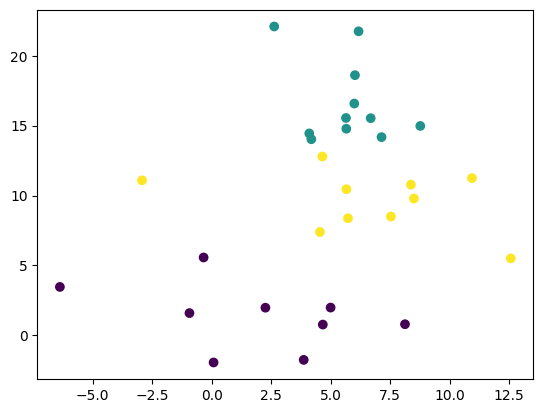

In [6]:
plt.scatter(samples[:, 0], samples[:, 1], c=sampleTag)
plt.show()

In [40]:
from sklearn.cluster import KMeans, k_means
from sklearn.metrics import silhouette_score

In [8]:
# Use the KMeans class from sklearn.cluster
model = KMeans(n_clusters=3, init='random', n_init=10, random_state=42)
model.fit(samples)

,n_clusters,3
,init,'random'
,n_init,10
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,42
,copy_x,True
,algorithm,'lloyd'


In [9]:
model.cluster_centers_

array([[ 1.81581065,  1.3855428 ],
       [ 7.97954595,  9.00531267],
       [ 4.97703516, 15.87480339]])

In [10]:
model.labels_

array([2, 1, 1, 2, 1, 2, 1, 2, 0, 0, 0, 0, 1, 2, 2, 2, 2, 0, 0, 2, 2, 0,
       1, 2, 1, 1, 2, 0, 0, 2])

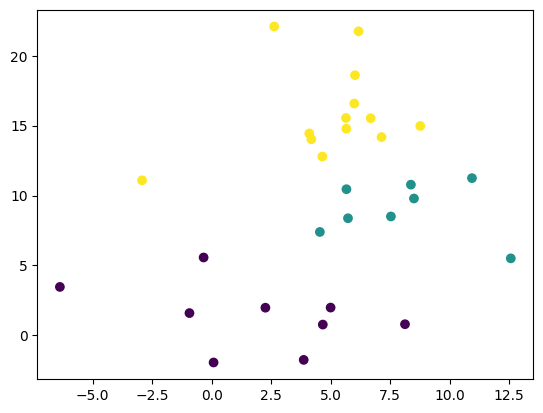

In [11]:
plt.scatter(samples[:, 0], samples[:, 1], c=model.labels_)
plt.show()

In [12]:
centroids, labels, inertia = k_means(samples, n_clusters=3, init='random', n_init=10, random_state=24) 

In [13]:
centroids

array([[ 1.81581065,  1.3855428 ],
       [ 4.97703516, 15.87480339],
       [ 7.97954595,  9.00531267]])

In [14]:
labels

array([1, 2, 2, 1, 2, 1, 2, 1, 0, 0, 0, 0, 2, 1, 1, 1, 1, 0, 0, 1, 1, 0,
       2, 1, 2, 2, 1, 0, 0, 1])

In [15]:
inertia

487.8402737618916

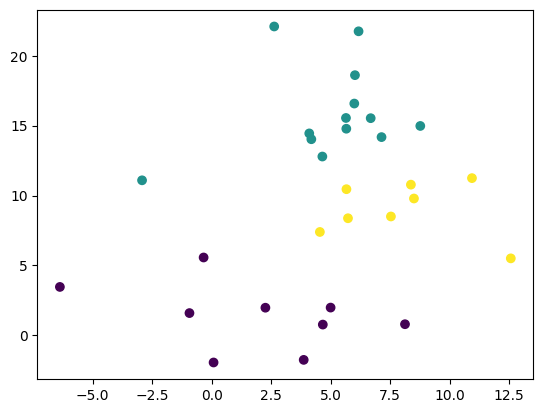

In [16]:
plt.scatter(samples[:, 0], samples[:, 1], c = labels)
plt.show()

In [25]:
def Elbow(S, k_max = 15, distMeas=L2, random_state = 42):
    krange = list(range(1, k_max + 1))
    sse_list = []
    for k in krange:
        sampleTag, clusterCents, SSE = kmeans(S, k)
        sse_list.append(SSE)
        print(f"SSE {k}={SSE}")
    # Calculate the first diff
    first_diff = []
    for i in range(1, len(sse_list)):
        first_diff.append(sse_list[i-1] - sse_list[i])
    # Calculate the second diff
    second_diff = []
    for j in range(1, len(first_diff)):
        second_diff.append(first_diff[j-1] - first_diff[j])
    target_index = np.argmin(second_diff) + 2
    k_optimal = krange[target_index]
    return k_optimal, sse_list



In [54]:
def silet_score(S, sampletag, cents, distMeas=L2):
    n_samples = S.shape[0]
    k = len(cents)
    
    # Precompute pairwise distances if needed (for efficiency)
    # But for simplicity, we'll compute as needed
    
    silhouette_scores = np.zeros(n_samples)
    
    for i in range(n_samples):
        # Get the cluster of the current point
        cluster_i = sampletag[i]
        
        # Get all points in the same cluster
        same_cluster_mask = (sampletag == cluster_i)
        same_cluster_points = S[same_cluster_mask]
        
        # Calculate a_i: average distance to points in same cluster
        if len(same_cluster_points) > 1:  # if not the only point in cluster
            distances = [distMeas(S[i], x) for x in same_cluster_points if not np.array_equal(S[i], x)]
            a_i = np.mean(distances)
        else:
            a_i = 0  # singleton cluster gets score 0
            
        # Calculate b_i: smallest average distance to other clusters
        other_clusters = [c for c in range(k) if c != cluster_i]
        b_i_values = []
        
        for c in other_clusters:
            other_cluster_points = S[sampletag == c]
            if len(other_cluster_points) > 0:
                distances = [distMeas(S[i], x) for x in other_cluster_points]
                b_i_values.append(np.mean(distances))
        
        if len(b_i_values) > 0:
            b_i = min(b_i_values)
        else:
            b_i = 0  # only one cluster exists
            
        # Calculate silhouette score for this point
        if a_i == 0 and b_i == 0:
            silhouette_scores[i] = 0  # special case
        else:
            silhouette_scores[i] = (b_i - a_i) / max(a_i, b_i)
    
    # Return the mean silhouette score across all samples
    return np.mean(silhouette_scores)

In [26]:
df = pd.read_excel("C:/Users/kbgs449/sysu/MLlabs/ML-Labs-25Fall-SYSU/city.xls")

In [27]:
# Remove rows with missing values
df = df.dropna(subset=['经度', '纬度'])


In [28]:
# Extract coordinates for kmeans
coordinates = df[['经度', '纬度']].values

In [29]:
k_optimal, sse = Elbow(coordinates)
print(f"the optimal k value is {k_optimal}")

SSE 1=771090.7973000003
SSE 2=247651.50675883974
SSE 3=169306.19618657403
SSE 4=111979.92841318034
SSE 5=78991.87026964361
SSE 6=64985.541124501055
SSE 7=54157.56976729791
SSE 8=49454.92695845986
SSE 9=45280.360562234026
SSE 10=42406.10357409337
SSE 11=34278.680558794615
SSE 12=32001.705859987516
SSE 13=29835.887689574327
SSE 14=27294.648293949078
SSE 15=25233.384530798725
the optimal k value is 11


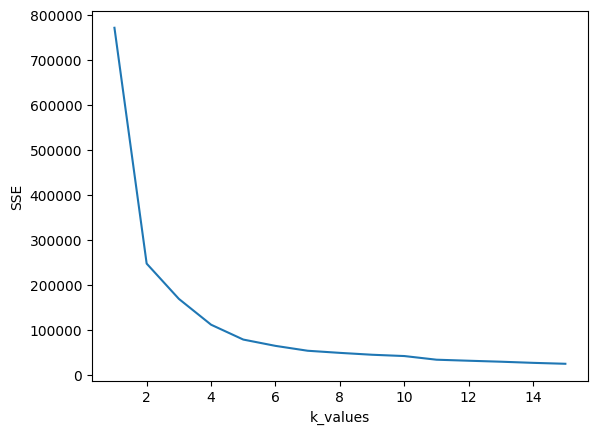

In [33]:
plt.figure()
plt.plot(range(1, 16), sse)
plt.xlabel("k_values")
plt.ylabel("SSE")
plt.show()

In [44]:
model = KMeans(n_clusters=11, init="k-means++", n_init=10, random_state=42)
model.fit(coordinates)

,n_clusters,11
,init,'k-means++'
,n_init,10
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,42
,copy_x,True
,algorithm,'lloyd'


In [45]:
print("The centers of each clusters:")
print(model.cluster_centers_)
print("The label of each data point:",model.labels_)
print("The inertia of the clusters:", model.inertia_)
print("The silouette_score:", silhouette_score(coordinates, model.labels_))

The centers of each clusters:
[[118.96882199  32.11410995]
 [ 83.55608696  42.12478261]
 [103.65431762  27.68188586]
 [111.86405542  32.86491184]
 [121.90380282  41.62046948]
 [110.83233618  24.49039886]
 [127.76558511  46.15510638]
 [114.88682081  38.10013487]
 [ 91.95529412  30.57682353]
 [104.40982533  36.05344978]
 [117.27811448  26.41670034]]
The label of each data point: [ 7  7  7 ... 10 10 10]
The inertia of the clusters: 33392.83756477345
The silouette_score: 0.3807400719714487


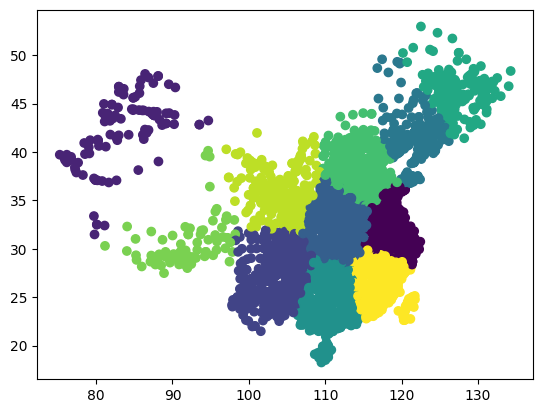

In [48]:
plt.scatter(coordinates[:, 0], coordinates[:, 1], c=model.labels_)
plt.show()

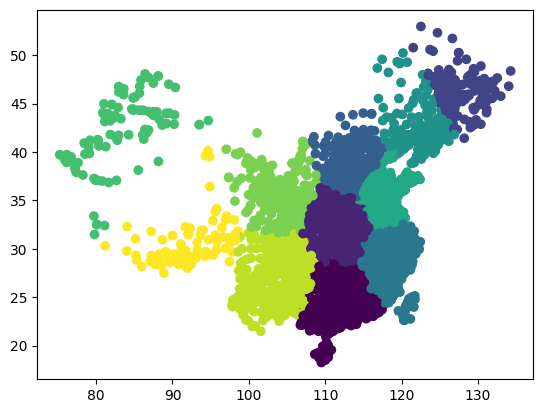

The SSE: 34278.680558794615
The silouetter_score is: 0.36755423493980416


In [56]:
sampleTag, cents, SSE = kmeans(coordinates, 11, L2)
score = silet_score(coordinates, sampleTag, cents, L2)
plt.scatter(coordinates[:, 0], coordinates[:, 1], c=sampleTag)
plt.show()
print("The SSE:", SSE)
print(f"The silouetter_score is: {score}")

### Image Segmentation

In [87]:
import matplotlib.image as mpimg
from skimage.transform import resize

In [91]:
# Load the image
image = mpimg.imread("C:/Users/kbgs449/image.jpg")
img = resize(image, (500, 500), anti_aliasing=True)
print(f"Image.shape: {img.shape}")
print(f"Image.dtype: {img.dtype}")
# Reshape the image to an array of pixels
height, width, channels = img.shape
pixels = img.reshape(-1, channels)
sampleTag, cents, SSE = kmeans(pixels, 2, L2)
# Reconstruct the segmented image
segmented_img = cents[sampleTag].reshape(height, width, channels)
# Create a label map
label_map = sampleTag.reshape(height, width)
# score = silet_score(pixels, sampleTag, cents,L2)
print("SSE = ", SSE)
# print("Silouette_score = ", score)


Image.shape: (500, 500, 3)
Image.dtype: float64
SSE =  10908.232207421453


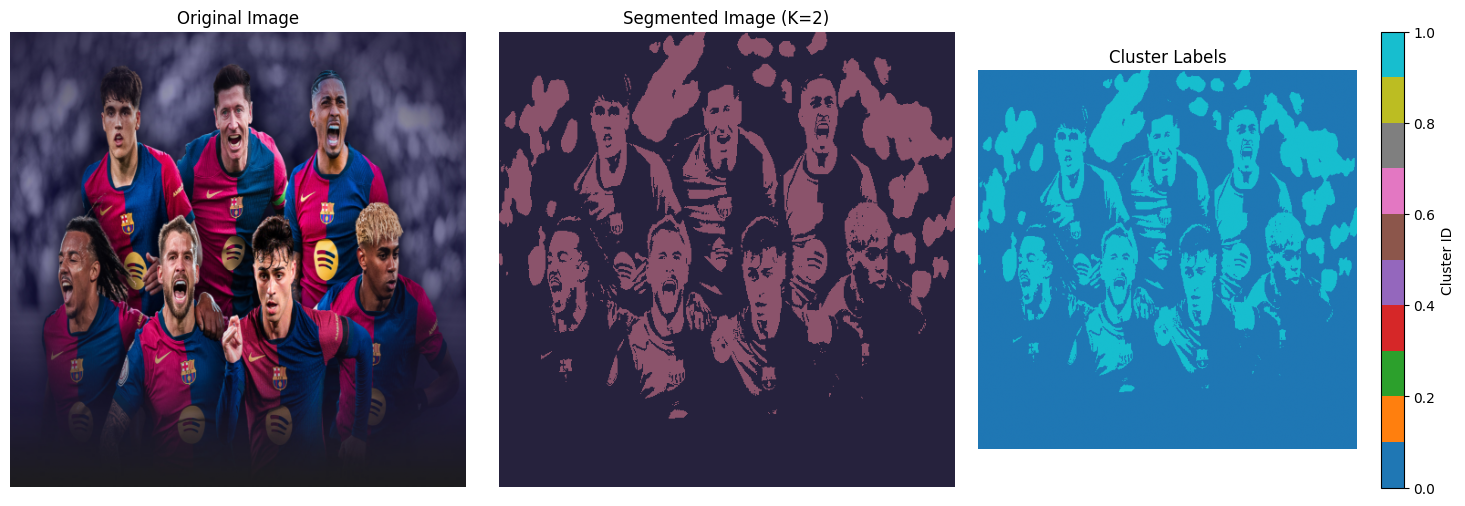

In [92]:
plt.figure(figsize=(15, 5))
    
# Original image
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')

# Segmented image
plt.subplot(1, 3, 2)
plt.imshow(segmented_img)
plt.title('Segmented Image (K=2)')
plt.axis('off')

# Label map
plt.subplot(1, 3, 3)
plt.imshow(label_map, cmap='tab10')
plt.title('Cluster Labels')
plt.axis('off')
plt.colorbar(label='Cluster ID')

plt.tight_layout()
plt.show()